In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple
import os
import flwr as fl
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR10
from torchsummary import summary
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from enum import Enum
from tqdm import tqdm
import gc
from numba import cuda
import networkx as nx
import random
import time
import enum
import threading
from matplotlib import pyplot as plt
from zod import ZodFrames
from zod import ZodSequences
import zod.constants as constants
from zod.constants import Camera, Lidar, Anonymization, AnnotationProject
import json
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime
import requests
import cv2
from flask import Flask, request, jsonify
import multiprocessing
from zod.visualization.oxts_on_image import visualize_oxts_on_image
from zod.constants import Camera
from zod.data_classes.calibration import Calibration
from zod.data_classes.oxts import EgoMotion
from zod.utils.polygon_transformations import polygons_to_binary_mask
from zod.utils.geometry import (
    get_points_in_camera_fov,
    project_3d_to_2d_kannala,
    transform_points,
)
import pytorch_lightning as pl
import segmentation_models_pytorch as smp
from pprint import pprint
from torch.utils.data import DataLoader
from PIL import Image

/tmp/ipykernel_1572746/3977172901.py:42: DeprecationWarning: The 'zod.data_classes.oxts' module has been deprecated and will be removed in a future version. Please use the 'zod.data_classes.ego_motion' module instead.
  from zod.data_classes.oxts import EgoMotion


## static params

In [2]:
NUM_OUTPUT = 51
IMG_SIZE = 256
RUN_PRETRAINED = True
BATCH_SIZE = 8
VAL_FACTOR = 0.15
SUBSET_FACTOR = 0.03
USE_GPU = True
NUM_GLOBAL_ROUNDS = 3
NUM_LOCAL_EPOCHS = 3
PRINT_DEBUG_DATA = True
NUM_WORKERS = 4 # os.cpu_count()
FRAMES_IMAGE_MEAN = [0.337, 0.345, 0.367]
FRAMES_IMAGE_STD = [0.160, 0.180, 0.214]
DEVICE = torch.device("cuda" if USE_GPU else "cpu")
TRAIN_FRAMES_PATH = "../GroundTruth/training_seg_annotated_frames.json"
VAL_FRAMES_PATH = "../GroundTruth/validation_seg_annotated_frames.json"
STORED_GROUND_TRUTH_PATH = "cached_gt/hp_gt_smp.json"
STORED_BALANCED_DS_PATH = "cached_gt/balanced_frames.txt"
DATASET_ROOT = "/mnt/ZOD"
ZENSEACT_DATASET_ROOT = "/staging/dataset_donation/round_2"

TARGET_DISTANCES = [5, 10, 15, 20, 25, 30, 35, 40, 50, 60, 70, 80, 95, 110, 125, 145, 165]

with open("frames_with_less_than_165m_hp.json") as f:
    short_frames = json.load(f)
UNUSED_FRAMES = set(short_frames)

print(f"PyTorch={torch.__version__}. Pytorch vision={torchvision.__version__}. Flower={fl.__version__}")
print(f"Training will run on: {DEVICE}s")

""" path to tensor board persistent folders"""
now = datetime.now().strftime("%Y-%m-%d_%H:%M:%S")
TB_PATH = f"TensorBoard/runs{now}"
TB_CENTRALIZED_SUB_PATH = "TensorBoard_Centralized/loss"
TB_FEDERATED_SUB_PATH = "TensorBoard_Federated/loss"
TB_SWARM_SUB_PATH = "TensorBoard_Swarm/loss"

PyTorch=2.0.0+cu117. Pytorch vision=0.15.1+cu117. Flower=1.3.0
Training will run on: cudas


## datasets

In [54]:
class ZODImporter:
    def __init__(
        self,
        root=DATASET_ROOT,
        subset_factor=SUBSET_FACTOR,
        img_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        tb_path=TB_PATH,
        zod_frames=None,
        training_frames=None, 
        validation_frames=None
    ):
        if(zod_frames == None):
            self.zod_frames = ZodFrames(dataset_root=root, version='full')
            self.training_frames_all = self.zod_frames.get_split(constants.TRAIN)
            self.validation_frames_all = self.zod_frames.get_split(constants.VAL)
            
            self.training_frames = list(self.training_frames_all)[: int(len(self.training_frames_all) * subset_factor)]
            self.validation_frames = list(self.validation_frames_all)[: int(len(self.validation_frames_all) * subset_factor)]

            self.training_frames = [x for x in tqdm(self.training_frames) if self.is_valid(x)]
            self.validation_frames = [x for x in tqdm(self.validation_frames) if self.is_valid(x)]
        else:
            self.zod_frames = zod_frames
            self.training_frames = training_frames
            self.validation_frames = validation_frames
            
        print("length of training_frames subset:", len(self.training_frames))
        print("length of test_frames subset:", len(self.validation_frames))

        self.img_size = img_size
        self.batch_size = batch_size
        self.tb_path = tb_path

        
    def is_valid(self, frame_id):
        return frame_id not in UNUSED_FRAMES
        
    def load_datasets(self, num_clients: int):
        seed = 42
        transform = transforms.Compose([
            transforms.ToTensor(),
            #transforms.Normalize(FRAMES_IMAGE_MEAN, FRAMES_IMAGE_STD),
            transforms.Resize(size=(self.img_size, self.img_size), antialias=True)
        ])

        trainset = ZodDataset(zod_frames=self.zod_frames, frames_id_set=self.training_frames, transform=transform)
        testset = ZodDataset(zod_frames=self.zod_frames, frames_id_set=self.validation_frames, transform=transform)

        # Split training set into `num_clients` partitions to simulate different local datasets
        partition_size = len(trainset) // num_clients

        lengths = [partition_size]
        if num_clients > 1:
            lengths = [partition_size] * (num_clients - 1)
            lengths.append(len(trainset) - sum(lengths))

        datasets = random_split(trainset, lengths, torch.Generator().manual_seed(seed))

        # Split each partition into train/val and create DataLoader
        trainloaders, valloaders = [], []
        lengths_train, lengths_val = [], []
        for ds in datasets:
            len_val = int(len(ds) * VAL_FACTOR)
            len_train = int(len(ds) - len_val)
            lengths_train.append(len_train)
            lengths_val.append(len_val)
            lengths = [len_train, len_val]
            ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(seed))
            trainloaders.append(DataLoader(ds_train,batch_size=self.batch_size, shuffle=True, num_workers=NUM_WORKERS))
            valloaders.append(DataLoader(ds_val, batch_size=self.batch_size, num_workers=NUM_WORKERS))

        len_complete_val = int(len(trainset) * VAL_FACTOR)
        len_complete_train = int(len(trainset) - len_complete_val)
        train_split, val_split = random_split(
            trainset,
            [len_complete_train, len_complete_val],
            torch.Generator().manual_seed(seed),
        )

        completeTrainloader = DataLoader(train_split, batch_size=self.batch_size, num_workers=NUM_WORKERS)
        completeValloader = DataLoader(val_split, batch_size=self.batch_size, num_workers=NUM_WORKERS)

        testloader = DataLoader(testset, batch_size=self.batch_size, num_workers=NUM_WORKERS)

        """report to tensor board"""
        save_dataset_tb_plot(self.tb_path, lengths_train, "training", seed)
        save_dataset_tb_plot(self.tb_path, lengths_val, "validation", seed)

        return (
            trainloaders,
            valloaders,
            testloader,
            completeTrainloader,
            completeValloader,
        )

class ZodDataset(Dataset):
    def __init__(
        self,
        zod_frames,
        frames_id_set,
        transform=None,
        target_transform=None,
    ):
        self.zod_frames = zod_frames
        self.frames_id_set = frames_id_set
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.frames_id_set)
    
    def __getitem__(self, idx):
        
        # load frame
        frame_idx = self.frames_id_set[idx]
        frame = self.zod_frames[frame_idx]
        
        # get image
        image_path = frame.info.get_key_camera_frame(Anonymization.DNAT).filepath
        image = np.array(Image.open(image_path).convert("RGB"))
        # extract ground truth
        label = get_ground_truth(self.zod_frames, frame_idx)
        
        # create sample
        sample = dict(image=image, label=label)
        
        # resize images
        image = np.array(Image.fromarray(sample["image"]).resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR))

        # convert to other format HWC -> CHW
        sample["image"] = np.moveaxis(image, -1, 0)
        sample["label"] = np.expand_dims(label, 0)
        
        return sample

def get_ground_truth(zod_frames, frame_id):
    # get frame
    zod_frame = zod_frames[frame_id]

    # extract oxts
    oxts = zod_frame.oxts

    # get timestamp
    key_timestamp = zod_frame.info.keyframe_time.timestamp()

    try:
        # get posses associated with frame timestamp
        current_pose = oxts.get_poses(key_timestamp)

        # transform poses
        all_poses = oxts.poses
        transformed_poses = np.linalg.pinv(current_pose) @ all_poses

        # get translations
        translations = transformed_poses[:, :3, 3]

        # calculate acc diff distance
        distances = np.linalg.norm(np.diff(translations, axis=0), axis=1)
        accumulated_distances = np.cumsum(distances).astype(int).tolist()

        # get the poses that each have a point having a distance from TARGET_DISTANCES
        pose_idx = [accumulated_distances.index(i) for i in TARGET_DISTANCES]
        used_poses = transformed_poses[pose_idx]

    except:
        #print("detected invalid frame: ", frame_id)
        return np.array([])

    #print(used_poses.shape)
    points = used_poses[:, :3, -1]
    return points.flatten()

def save_dataset_tb_plot(tb_path, sample_distribution, subtitle, seed):
    plt.bar(list(range(1, len(sample_distribution) + 1)), sample_distribution)
    plt.xlabel("Partitions")
    plt.ylabel("Samples")
    plt.suptitle("Distribution of samples")
    plt.title("%s, seed: %s" % (subtitle, seed)),

    """report to tensor board"""
    writer = SummaryWriter(tb_path)
    writer.add_figure("sample_distribution/%s" % (subtitle), plt.gcf(), global_step=0)
    writer.close()


def reshape_ground_truth(label, output_size=NUM_OUTPUT):
    return label.reshape(((NUM_OUTPUT // 3), 3))

def visualize_HP_on_image(zod_frames, frame_id, preds=None, showImg=True):
    """Visualize oxts track on image plane."""
    camera=Camera.FRONT
    zod_frame = zod_frames[frame_id]
    image = zod_frame.get_image(Anonymization.DNAT)
    calibs = zod_frame.calibration
    points_gt = get_ground_truth(zod_frames, frame_id)
    preds_row = preds.copy()
    points = reshape_ground_truth(points_gt)
    
    circle_size = 15
    
    # transform point to camera coordinate system
    T_inv = np.linalg.pinv(calibs.get_extrinsics(camera).transform)
    camerapoints = transform_points(points[:, :3], T_inv)

    # filter points that are not in the camera field of view
    points_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, camerapoints)
    points_in_fov = points_in_fov[0]

    # project points to image plane
    xy_array = project_3d_to_2d_kannala(
        points_in_fov,
        calibs.cameras[camera].intrinsics[..., :3],
        calibs.cameras[camera].distortion,
    )
    
    ground_truth_color = (19, 80, 41)
    preds_color = (161, 65, 137)
    
    points = []
    for i in range(xy_array.shape[0]):
        x, y = int(xy_array[i, 0]), int(xy_array[i, 1])
        cv2.circle(image, (x,y), circle_size, ground_truth_color, -1)
        points.append([x,y])
    
    """Draw a line in image."""
    def draw_line(image, line, color):
        return cv2.polylines(image.copy(), [np.round(line).astype(np.int32)], isClosed=False, color=color, thickness=20)
    
    image = draw_line(image, points, ground_truth_color)
    
    # transform and draw predictions 
    if(preds is not None):
        preds = reshape_ground_truth(preds)
        predpoints = transform_points(preds[:, :3], T_inv)
        predpoints_in_fov = get_points_in_camera_fov(calibs.cameras[camera].field_of_view, predpoints)
        predpoints_in_fov = predpoints_in_fov[0]
        
        xy_array_preds = project_3d_to_2d_kannala(
            predpoints_in_fov,
            calibs.cameras[camera].intrinsics[..., :3],
            calibs.cameras[camera].distortion,
        )
        preds = []
        for i in range(xy_array_preds.shape[0]):
            x, y = int(xy_array_preds[i, 0]), int(xy_array_preds[i, 1])
            cv2.circle(image, (x,y), circle_size, preds_color, -1)
            preds.append([x,y])
        
        #preds = preds[:(len(preds)//2)]
        image = draw_line(image, preds, preds_color)
        
    #plt.imsave(f'inference_{frame_id}.png', image)
    if(showImg):
        plt.clf()
        plt.axis("off")
        plt.imshow(image)
    #return image, points_gt, preds_row
    
def get_transformed_image(zod_frames, frame_id):
    frame = zod_frames[frame_id]
    image_path = frame.info.get_key_camera_frame(Anonymization.DNAT).filepath
    image = np.array(Image.open(image_path).convert("RGB"))
    image = np.array(Image.fromarray(image).resize((IMG_SIZE, IMG_SIZE), Image.BILINEAR))
    image = torch.from_numpy(image).permute(2, 0, 1).unsqueeze(0).to(DEVICE)
    print(image.shape)
    return image

def predict(model, zod_frames, frame_id):
    image = get_transformed_image(zod_frames, frame_id).to(DEVICE)
    outputs = model(image)
    preds = outputs.cpu().detach().numpy()
    return preds

## models

In [4]:
class PT_Model(pl.LightningModule):
    def __init__(self) -> None:
        super(PT_Model, self).__init__()
        self.model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
        self.is_pretrained = True

        # freeze parameters and replace head
        for param in self.model.parameters():
            param.requires_grad = False
        self.change_head_net()
        self.loss_fn = torch.nn.L1Loss()
        
        # pytorch imagenet calculated mean/std
        self.mean=[0.485, 0.456, 0.406]
        self.std=[0.229, 0.224, 0.225]
        
        self.inter_train_outputs = []
        self.inter_val_outputs = []
        self.inter_test_outputs = []

    def forward(self, image):
        # normalize image here
        mean = torch.tensor(self.mean).view(3, 1, 1).to(DEVICE)
        std = torch.tensor(self.std).view(3, 1, 1).to(DEVICE)
        
        image = (image - mean) / std
        label = self.model(image)
        return label

    def model_parameters(self):
        return self.model.fc.parameters()

    def change_head_net(self):
        num_ftrs = self.model.fc.in_features
        head_net = nn.Sequential(
            nn.Linear(num_ftrs, 1024, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(inplace=True),
            nn.Linear(512, NUM_OUTPUT, bias=True),
        )
        self.model.fc = head_net

    
    def shared_step(self, batch, stage):
        image = batch["image"]

        # Shape of the image should be (batch_size, num_channels, height, width)
        # if you work with grayscale images, expand channels dim to have [batch_size, 1, height, width]
        assert image.ndim == 4

        h, w = image.shape[2:]
        assert h % 32 == 0 and w % 32 == 0

        label = batch["label"]

        logits_label = self.forward(image)
        logits_label = logits_label.unsqueeze(dim=1)
        
        # Predicted mask contains logits, and loss_fn param `from_logits` is set to True
        loss = self.loss_fn(logits_label, label)

        return {
            "loss": loss,
        }

    def shared_epoch_end(self, outputs, stage):
        metrics = {
            f"{stage}_loss": outputs[-1]['loss'],
        }
        
        self.log_dict(metrics, prog_bar=True)

    def training_step(self, batch, batch_idx):
        output = self.shared_step(batch, "train")
        self.inter_train_outputs.append(output)
        return output

    def on_training_epoch_end(self):
        return self.shared_epoch_end(self.inter_train_outputs, "train")

    def validation_step(self, batch, batch_idx):
        output = self.shared_step(batch, "valid")
        self.inter_val_outputs.append(output)
        return output

    def on_validation_epoch_end(self):
        return self.shared_epoch_end(self.inter_val_outputs, "valid")

    def test_step(self, batch, batch_idx):
        output = self.shared_step(batch, "test")
        self.inter_test_outputs.append(output)
        return output

    def on_test_epoch_end(self):
        return self.shared_epoch_end(self.inter_test_outputs, "test")

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.0001)

## train

In [5]:
def train(model, train_dataloader, valid_dataloader, nr_epochs=NUM_LOCAL_EPOCHS):
    trainer = pl.Trainer(
        accelerator= 'gpu',
        max_epochs=nr_epochs,
    )

    trainer.fit(
        model, 
        train_dataloaders=train_dataloader, 
        val_dataloaders=valid_dataloader,
    )

    return trainer

def validate(trainer, model, valid_dataloader):
    valid_metrics = trainer.validate(model, dataloaders=valid_dataloader, verbose=False)
    pprint(valid_metrics)


def test(trainer, model, test_dataloader):
    test_metrics = trainer.test(model, dataloaders=test_dataloader, verbose=False)
    pprint(test_metrics)

## supervised

In [6]:
def load_HP(dataset_root):
    zod_frames = ZodFrames(dataset_root=dataset_root, version='full')
    training_frames_all = zod_frames.get_split(constants.TRAIN)
    validation_frames_all = zod_frames.get_split(constants.VAL)

    return zod_frames, training_frames_all, validation_frames_all

def is_valid(frame_id):
    return frame_id not in UNUSED_FRAMES
    
zod_frames, training_frames_all, validation_frames_all = load_HP(DATASET_ROOT)

training_frames = list(training_frames_all)[: int(len(training_frames_all) * SUBSET_FACTOR)]
validation_frames = list(validation_frames_all)[: int(len(validation_frames_all) * SUBSET_FACTOR)]

training_frames = [x for x in tqdm(training_frames) if is_valid(x)]
validation_frames = [x for x in tqdm(validation_frames) if is_valid(x)]

print(f'loaded {len(training_frames)} train frame ids.')
print(f'loaded {len(validation_frames)} val frame ids.')

Loading infos: 0it [00:00, ?it/s]

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 983040.00it/s]

loaded 2484 train frame ids.
loaded 293 val frame ids.


In [10]:
# get loaders
trainloaders, valloaders, testloader, completeTrainloader, completeValloader = ZODImporter(zod_frames=zod_frames,training_frames=training_frames,validation_frames=validation_frames).load_datasets(num_clients=1)

# create model
model = PT_Model()

# train supervised
trainer = train(model, completeTrainloader, completeValloader, nr_epochs=NUM_LOCAL_EPOCHS)

length of training_frames subset: 2484
length of test_frames subset: 293


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]

  | Name    | Type   | Params
-----------------------------------
0 | model   | ResNet | 12.3 M
1 | loss_fn | L1Loss | 0     
-----------------------------------
1.1 M     Trainable params
11.2 M    Non-trainable params
12.3 M    Total params
49.011    Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

/home/yasan/miniconda3/envs/zen/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('valid_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=3` reached.


In [12]:
# validate 
validate(trainer, model, completeValloader)

Initializing distributed: GLOBAL_RANK: 0, MEMBER: 1/2
Initializing distributed: GLOBAL_RANK: 1, MEMBER: 2/2
----------------------------------------------------------------------------------------------------
distributed_backend=nccl
All distributed processes registered. Starting with 2 processes
----------------------------------------------------------------------------------------------------

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1]
LOCAL_RANK: 1 - CUDA_VISIBLE_DEVICES: [0,1]
/home/yasan/miniconda3/envs/zen/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:225: PossibleUserWarning: Using `DistributedSampler` with the dataloaders. During `trainer.validate()`, it is recommended to use `Trainer(devices=1, num_nodes=1)` to ensure each sample/batch gets evaluated exactly once. Otherwise, multi-device settings use `DistributedSampler` that replicates some samples to make sure all devices have same batch size in case of uneven inputs.
  rank_zero_warn(


Validation: 0it [00:00, ?it/s]

/home/yasan/miniconda3/envs/zen/lib/python3.9/site-packages/pytorch_lightning/trainer/connectors/logger_connector/result.py:432: PossibleUserWarning: It is recommended to use `self.log('valid_loss', ..., sync_dist=True)` when logging on epoch level in distributed setting to accumulate the metric across devices.
  warning_cache.warn(


[{'valid_loss': 21.092461628575528}]


In [ ]:
# test
test(trainer, model, testloader)

torch.Size([1, 3, 256, 256])


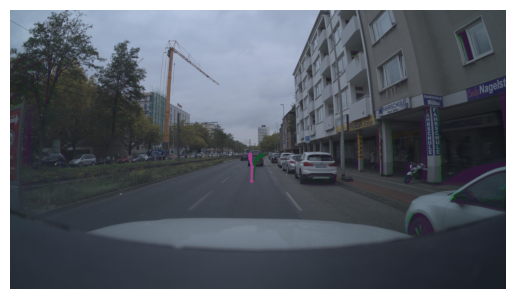

In [60]:
frame_id  =list(training_frames_all)[20]
pred = predict(model.to(DEVICE), zod_frames, frame_id)

visualize_HP_on_image(zod_frames, frame_id, pred)

In [ ]:
from IPython.core.display import display, HTML
display(HTML("<style>div.output_scroll { height: 64em; }</style>"))